In [1]:
import torch
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt
import cv2


In [19]:
def load_model():
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    model.eval()
    return model

def remove_background(model, input_file):
    input_image = Image.open(input_file)
    preprocess = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = preprocess(input_image).unsqueeze(0)

    if torch.cuda.is_available():
        input_tensor = input_tensor.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        # res = model(input_tensor)['out'][0]
        res = model(input_tensor)

    return res


In [35]:
import numpy as np
from copy import deepcopy

img_path = '../../../assets/People1.jpg'

deeplab_model = load_model()

# freezing the layer
for param1, param2, param3 in zip(deeplab_model.backbone.parameters(), deeplab_model.classifier.parameters(), deeplab_model.aux_classifier.parameters()):
    param1.requires_grad = False 
    param2.requires_grad = False 
    param3.requires_grad = False 

deeplab_model_added = deepcopy(deeplab_model)

deeplab_model_added.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))

for param in deeplab_model_added.classifier[-1].parameters():
    param.requires_grad = True

res = remove_background(deeplab_model_added, img_path)


Using cache found in /home/rohit/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rohit/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rohit/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
res['out'][0].shape

torch.Size([1, 450, 308])

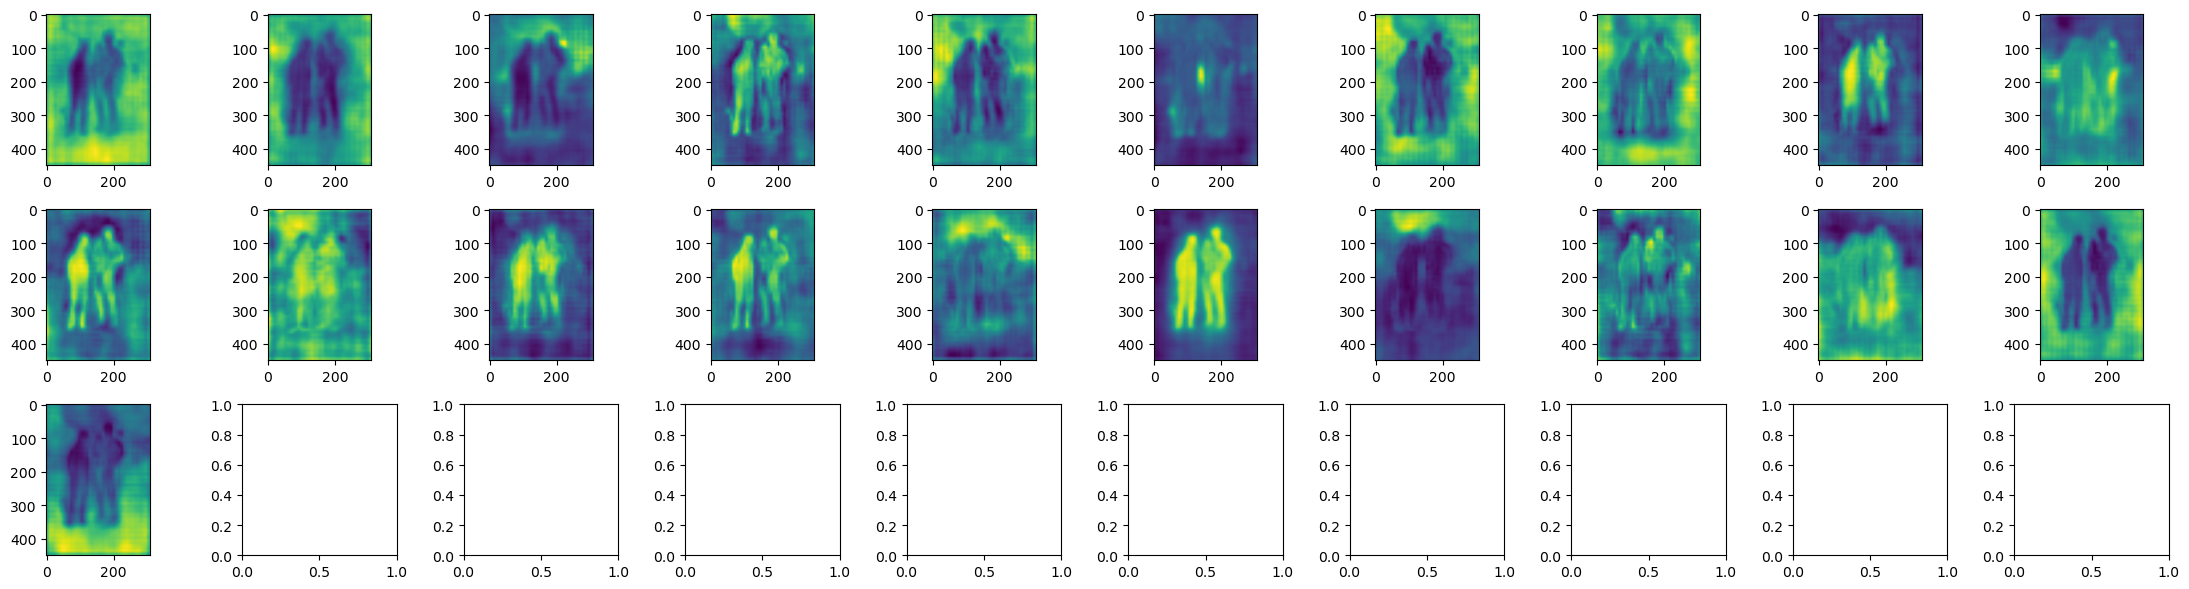

In [4]:
fig, axes = plt.subplots(3, 10, figsize=(22, 6))
axes = axes.ravel()

for i in range(21):
    axes[i].imshow(res[i])

plt.tight_layout()
plt.show()


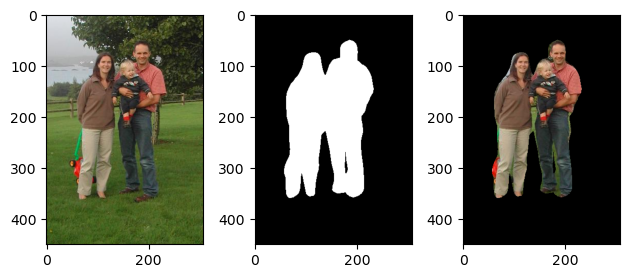

In [5]:
res_ = res.argmax(0).numpy()
res_ = (res_/res_.max() * 255).astype('uint8')

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
h, w, *_ = img.shape
res_ = cv2.cvtColor(cv2.resize(res_, (w, h)), cv2.COLOR_GRAY2RGB)

plt.subplot(131)
plt.imshow(img)

plt.subplot(132)
plt.imshow(res_)

plt.subplot(133)
plt.imshow(cv2.bitwise_and(img, res_))

plt.tight_layout()
plt.show()


In [86]:
# deeplab_model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))